In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

import anndata
import scanpy as sc
%matplotlib inline

plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

In [1]:
adata = sc.read_h5ad('./rna_raw.h5ad')  ## output from cellranger

## Match 10X RNA and CellID barcode, from 10X website
ref = pd.read_csv('./cellranger/3M-february-2018.txt.gz', header=None,sep='\t', index_col=0)
ref.columns = ['CellID']

## preprocess

In [5]:
in_path = './result/hgmm_mix/CellID/'
fig_path = './result/hgmm_mix/CellID/'
os.makedirs(fig_path, exist_ok=True)

In [6]:
data = pd.read_csv('./processed.txt', sep='\t', header=None)  ## processed.txt generated from 01.preprocess.sh
data.columns = ['Barcode','UMI','CellID']
data.drop_duplicates(subset=['Barcode','UMI'], inplace=True)

bcs = adata.obs_names
bcs = np.array([item.split('-')[0] for item in bcs])
bcs = ref.loc[bcs,'CellID'].values

signal = data[data.Barcode.isin(bcs)]
noise = data[~data.Barcode.isin(bcs)]

signal_counts = signal.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()
noise_counts = noise.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()

out = pd.DataFrame({'CellID':list(signal_counts['CellID']) + list(noise_counts['CellID']),
                    'Class':['Cell']*len(signal_counts)+['Non-cell']*len(noise_counts)})
# out.to_csv(in_path + 'nCellID.txt', sep='\t')

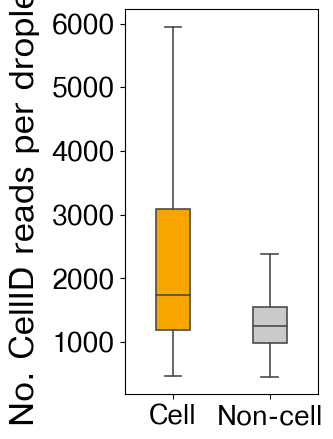

In [8]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. CellID reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

plt.savefig(fig_path + 'nCellID.pdf',dpi=100,format='pdf',bbox_inches='tight')

In [9]:
a = out.loc[out.Class=='Cell','CellID'].values
b = out.loc[out.Class!='Cell','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(41.08811799957815, 0.0)


In [11]:
sg = pd.DataFrame(signal.groupby('Barcode')['CellID'].value_counts())
bk = pd.DataFrame(noise.groupby('Barcode')['CellID'].value_counts())

signal_num = sg.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
cells = sg.index.get_level_values('Barcode')
cells = list(dict.fromkeys(cells))
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(cells, signal_num) ])).T
df.fillna(0, inplace=True)
df = df.astype(int)
df.columns = ['rank_'+str(i+1) for i in range(df.shape[1])]
df_ratio = df.div(df.sum(axis=1), axis='rows')

noise_num = bk.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
noise_barcode = bk.index.get_level_values('Barcode')
noise_barcode = list(dict.fromkeys(noise_barcode))
df_noise = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(noise_barcode, noise_num) ])).T
df_noise.fillna(0, inplace=True)
df_noise = df_noise.astype(int)
df_noise.columns = ['rank_'+str(i+1) for i in range(df_noise.shape[1])]
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df.iloc[:,:10].values.reshape(-1,))+list(df_noise.iloc[:,:10].values.reshape(-1,)),
                    'Rank':list(df.columns[:10])*df.shape[0]+list(df_noise.columns[:10])*df_noise.shape[0],
                    'Class':['Cell']*(df.shape[0]*10) + ['Non-cell']*(df_noise.shape[0]*10)})

df.to_csv(in_path + 'signal_rank.txt', sep='\t')
df_noise.to_csv(in_path + 'noise_rank.txt', sep='\t')
out.to_csv(in_path + 'CellID_rank.txt', sep='\t')

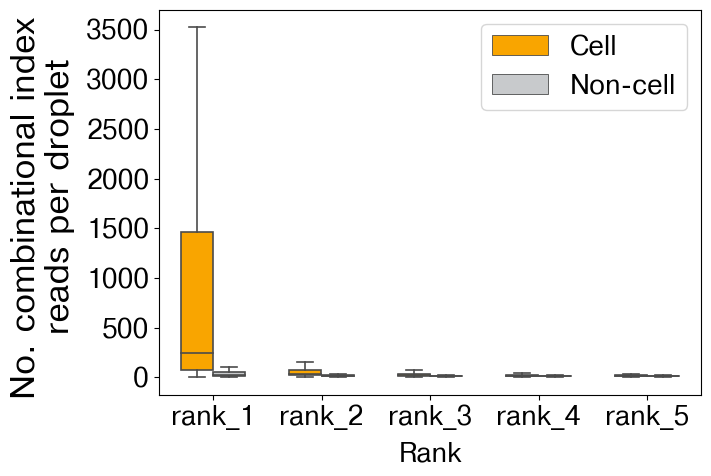

In [16]:
out = pd.read_csv(in_path + 'CellID_rank.txt', sep='\t')
out = out.loc[out['Rank'].isin(['rank_1','rank_2','rank_3','rank_4','rank_5']),:]

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index \n reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)
plt.savefig(fig_path + 'rank_nCellID.pdf',dpi=100,format='pdf', bbox_inches='tight')

In [13]:
df_ratio = df.div(df.sum(axis=1), axis='rows')
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df_ratio.iloc[:,:10].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:10].values.reshape(-1,)),
                    'Rank':list(df_ratio.columns[:10])*df_ratio.shape[0]+list(df_noise_ratio.columns[:10])*df_noise_ratio.shape[0],
                    'Class':['Cell']*(df_ratio.shape[0]*10) + ['Non-cell']*(df_noise_ratio.shape[0]*10)})

out.to_csv(in_path + 'CellID_rank_ratio.txt', sep='\t')

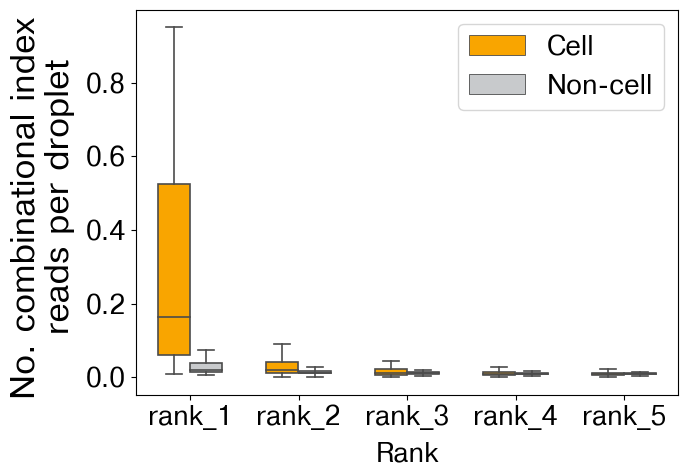

In [22]:
out = pd.read_csv(in_path + 'CellID_rank_ratio.txt', sep='\t', index_col=0)
out = out.loc[out['Rank'].isin(['rank_1','rank_2','rank_3','rank_4','rank_5']),:]

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index \n reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

plt.savefig(fig_path + 'rank_ratio_CellID.pdf',dpi=100,format='pdf', bbox_inches='tight')

In [15]:
signal_cellid = signal.groupby('Barcode')['CellID'].agg(lambda x:x.value_counts().index[0]).to_frame()
tmp = signal_cellid.copy()
df['total'] = df.sum(axis=1)
tmp['total'] = df.loc[tmp.index,'total']
tmp.loc[:,'rank1'] = df.loc[tmp.index, 'rank_1']
tmp.loc[:,'rank1_ratio'] = tmp.loc[:,'rank1']/tmp['total']
tmp.loc[:,'rank2'] = df.loc[tmp.index, 'rank_2']
tmp.loc[:,'rank2_ratio'] = tmp.loc[:,'rank2']/tmp['total']
tmp.to_csv(in_path + 'result.txt', sep='\t')

In [23]:
df = pd.read_csv(in_path + 'signal_rank.txt', sep='\t', index_col=0)
df_noise = pd.read_csv(in_path + 'noise_rank.txt', sep='\t', index_col=0)

tmp1 = df.iloc[:,:2]
tmp2 = df_noise.iloc[:,:2]
tmp1['Class'] = 'Cell'
tmp2['Class'] = 'Non-cell'
out = pd.concat([tmp1, tmp2])
out['CellID'] = out['rank_1']/out['rank_2']

/tmp/ipykernel_1458329/1341517317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Class'] = 'Cell'
/tmp/ipykernel_1458329/1341517317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['Class'] = 'Non-cell'


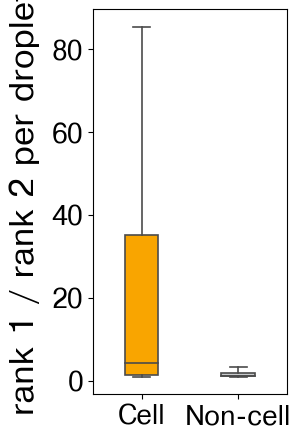

In [24]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank 1 / rank 2 per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

plt.savefig(fig_path + 'CellID_rank1_rank2.pdf',dpi=100, format='pdf',bbox_inches='tight')

In [25]:
a = out.loc[out.Class=='Cell','CellID'].values
b = out.loc[out.Class!='Cell','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(37.820623085383694, 3.773779275096459e-291)


## after CellID quality control

In [ ]:
df_signal = pd.read_csv('./result/hgmm_mix/CellID/signal_rank.txt', sep='\t', index_col=0)
df_noise = pd.read_csv('./result/hgmm_mix/CellID/noise_rank.txt', sep='\t', index_col=0)

In [ ]:
df = pd.read_csv('./result/hgmm_mix/CellID/result_qc.txt', sep='\t', index_col=0)
df = df.loc[df['species'].isin(['GRCh38','GRCm39']),:]
df['CellID_species'] = [i[-8:] for i in df['CellID'].values]
df['CellID_clump'] = [i[:-8] for i in df['CellID'].values]

df['species_CellID'] = 'GRCm39'
df.loc[df['CellID_species']=='CAGATAGT','species_CellID']='GRCh38'
df = df.loc[df['total_counts']>=1000,:]
df = df.loc[df['qc']=='1']

df_signal = df_signal.loc[df['CellID_Barcode'].values,:]

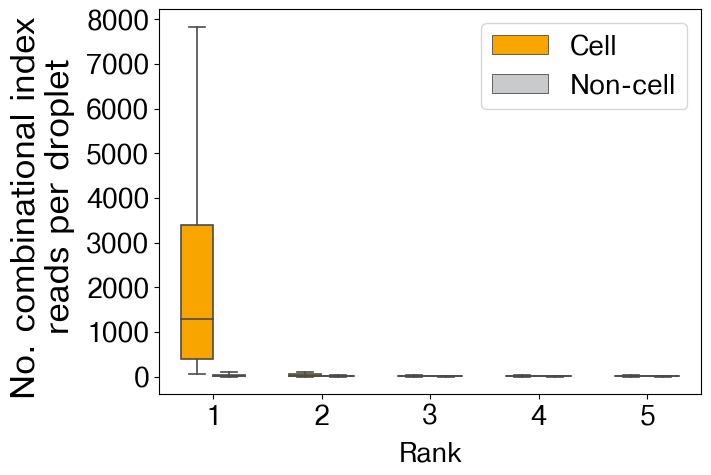

In [49]:
out = pd.DataFrame({'CellID': list(df_signal.iloc[:,:5].values.reshape(-1,))+list(df_noise.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal.shape[0]+list([1,2,3,4,5])*df_noise.shape[0],
                    'Class':['Cell']*(df_signal.shape[0]*5) + ['Non-cell']*(df_noise.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index \n reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)
plt.savefig(fig_path + 'rank_nCellID_filter.pdf',dpi=100,format='pdf', bbox_inches='tight')

In [27]:
df_signal_ratio = df_signal.div(df_signal.sum(axis=1), axis='rows')
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

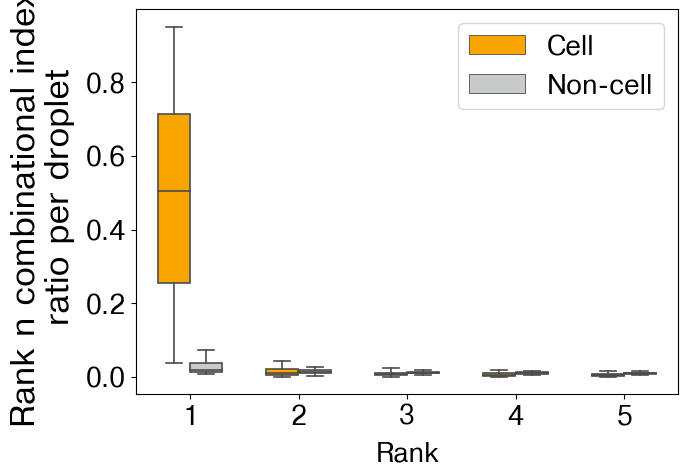

In [50]:
out = pd.DataFrame({'CellID': list(df_signal_ratio.iloc[:,:5].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal_ratio.shape[0]+list([1,2,3,4,5])*df_noise_ratio.shape[0],
                    'Class':['Cell']*(df_signal_ratio.shape[0]*5) + ['Non-cell']*(df_noise_ratio.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Rank n combinational index \n ratio per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)
plt.savefig(fig_path + 'rank_ratio_CellID_filter.pdf',dpi=100,format='pdf', bbox_inches='tight')

In [52]:
d1 = df_signal.sum(axis=1).astype(int)
d2 = df_noise.sum(axis=1).astype(int)
d1 = pd.DataFrame(d1)
d2 = pd.DataFrame(d2)
d1.columns = ['CellID']
d2.columns = ['CellID']
d1['Class'] = 'Cell'
d2['Class'] = 'Non-cell'

out =pd.concat([d1,d2])

In [53]:
a = out.loc[out.Class=='Cell','CellID'].values
b = out.loc[out.Class!='Cell','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

p = ttest_ind(a,b, alternative='greater', equal_var=False)[1]

Performing t-test analysis...
(40.024683994874145, 1.0055108397820432e-295)


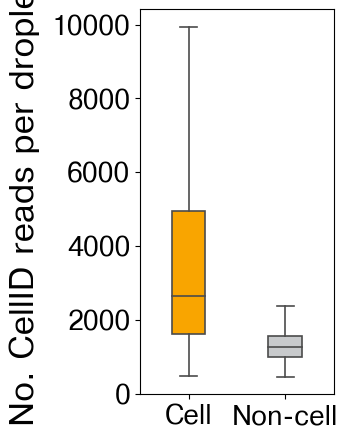

In [54]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. CellID reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

plt.savefig(fig_path + 'nCellID_filter.pdf',dpi=100,format='pdf',bbox_inches='tight')

In [2]:
tmp1 = df_signal.iloc[:,:2]
tmp2 = df_noise.iloc[:,:2]
tmp1['Class'] = 'Cell'
tmp2['Class'] = 'Non-cell'
out = pd.concat([tmp1, tmp2])
out['CellID'] = out['rank_1']/out['rank_2']

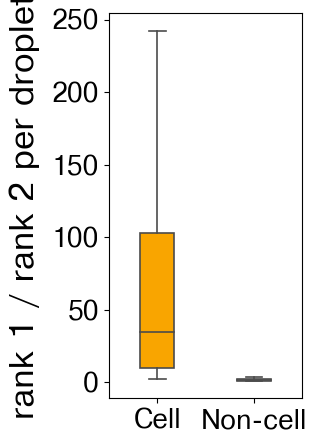

In [56]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank 1 / rank 2 per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

plt.savefig(fig_path + 'CellID_rank1_rank2_filter.pdf',dpi=100, format='pdf',bbox_inches='tight')

In [57]:
a = out.loc[out.Class=='Cell','CellID'].values
b = out.loc[out.Class!='Cell','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(39.17101876980767, 4.184516812399106e-285)
